In [1]:
#### Homework Assignment 1: Adversarial Examples

## This jupyter notebook aims to get familiar with the untargted and targeted methods for generating adversarial examples
## We will try to attack a pretrained ImageNet ResNet50 model on a given ImageNet image .

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

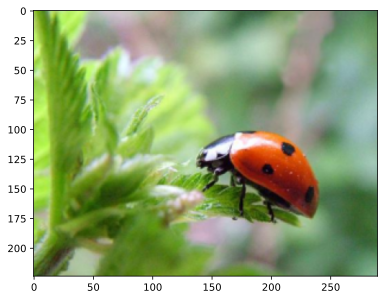

In [17]:
## Load the sample ImageNet image (which is an image of ladybug) and visualize it

from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
ladybug_img = Image.open("ladybug.jpeg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
ladybug_tensor = preprocess(ladybug_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(ladybug_tensor[0].numpy().transpose(1,2,0))

In [18]:
## Prepare the ImageNet ResNet50 classification model
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode
model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# form the prediction on the clean ladybug image
pred_ladybug = model(norm(ladybug_tensor))
print(imagenet_classes[pred_ladybug.max(dim=1)[1].item()])

ladybug


In [20]:
# 301 is the class index corresponding to the ImageNet class "ladybug"
# form the cross-entropy loss on the prediction according to the ground truth label
print(nn.CrossEntropyLoss()(model(norm(ladybug_tensor)),torch.LongTensor([301])).item())

0.06670434772968292


In [21]:
## Your task 1: implement the simple version of untargeted PGD attack - make necessary changes to the following code
import torch
import torch.optim as optim
import torch.nn as nn

epsilon = 2./255
criterion = nn.CrossEntropyLoss()
alpha = 0.1
num_iterations = 30

perturbated_img = ladybug_tensor.clone().detach()
with torch.no_grad():
    outputs = model(ladybug_tensor)
    _, predicted_index = torch.max(outputs, 1)


true_labels = torch.tensor([predicted_index.item()])

# delta stores the generated perturbation and updates its value iteratively
delta = torch.tensor(torch.zeros_like(perturbated_img), requires_grad=True)
delta.data = delta.data * 2 * epsilon - epsilon
optimizer = optim.SGD([delta], lr=alpha)

for t in range(num_iterations):
    optimizer.zero_grad()

    # Ensure pert_img is properly tracked for gradient computation
    perturbated_img.requires_grad = True
    pred = model(perturbated_img + delta)
    loss = criterion(pred, true_labels)
    loss.backward(retain_graph=True)
    pert_img_grad = torch.autograd.grad(loss, perturbated_img)[0]

    if pert_img_grad is not None:
            # Update perturbation using the gradient
            delta.data = delta.data + alpha * pert_img_grad

            # Clip perturbation to stay within the epsilon ball
            delta.data = torch.clamp(delta.data, -epsilon, epsilon)

            # Update perturbed image by adding the clipped perturbation to the original image
            perturbated_img = ladybug_tensor + delta.data

            # Clip perturbed image to stay within [0, 1]
            perturbated_img.data = torch.clamp(perturbated_img.data, 0.0, 1.0)
    if t % 5 == 0:
      print(t, loss.item())

# pred stores the model predicted logits of the genreated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

/tmp/ipykernel_3338/1139943618.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta = torch.tensor(torch.zeros_like(perturbated_img), requires_grad=True)


0 0.23269036412239075
5 11.389144897460938
10 18.884929656982422
15 20.13874053955078
20 26.43000602722168
25 17.96688461303711
True class probability: 2.5574259376881514e-10


In [22]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  weevil
Predicted probability: 0.9999346733093262


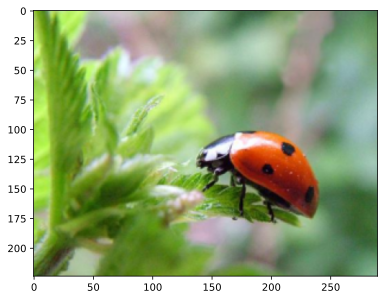

In [23]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007843138..1.0078431].


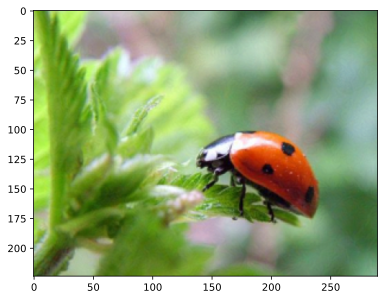

In [24]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

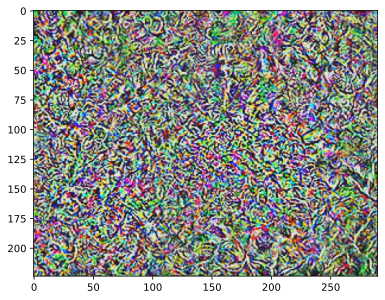

In [25]:
# plot the generated adversarial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [26]:
## Your task 2: implement the basic version of targeted attack 
## Targeted label: zebra; Class index: 340
delta = torch.zeros_like(ladybug_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(ladybug_tensor + delta))
    # since using SGD to update delta here, we add a minus in front of the robust loss
    loss = -(nn.CrossEntropyLoss()(pred, torch.LongTensor([301])) - 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([340])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    # guarantee x_{t+1} within the perturbation ball
    delta.data.clamp_(-epsilon, epsilon)

0 18.930261611938477
10 1.2054803371429443
20 -9.57580280303955
30 -23.803321838378906
40 -29.502016067504883
50 -36.53977584838867
60 -42.622169494628906
70 -46.64335250854492
80 -48.56863021850586
90 -52.76816940307617


In [27]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  zebra
Predicted probability: 0.9999997615814209


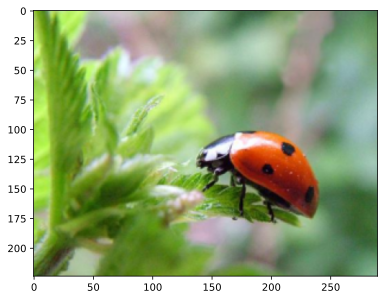

In [28]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007843138..1.0078431].


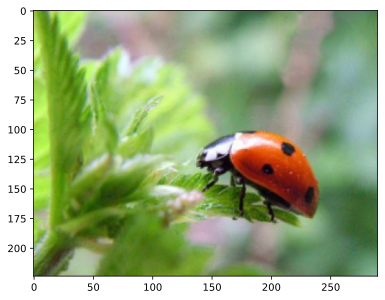

In [29]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

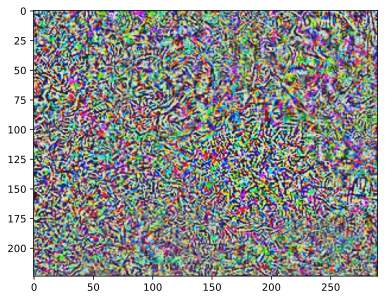

In [30]:
# plot the generated adversasrial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))